In [1]:
import os

import matplotlib.pyplot as plt

import numpy as np 

from PIL import Image

from keras.models import Model

from keras.layers import Dense, BatchNormalization, Activation

from keras.layers.convolutional import Conv2D

from keras.layers.convolutional import MaxPooling2D

from keras.layers import UpSampling2D

from keras.layers import Concatenate

from keras.layers import Reshape

from keras.layers import Input

from keras.optimizers import Adam

from keras.callbacks import TensorBoard

import keras.backend as K

Using TensorFlow backend.


In [41]:
def DIP(input_shape):
    
    model_input = Input(shape = input_shape)
    
    conv1 = Conv2D(64, kernel_size=3, padding="same")(model_input)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    
    #skip
    conv2 = Conv2D(64, kernel_size=3, padding="same")(conv1)
    #conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    
    pool1 = MaxPooling2D()(conv2)
    
    conv3 = Conv2D(128, kernel_size=3, padding="same")(pool1)
    #conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    
    #skip
    conv4 = Conv2D(128, kernel_size=3, padding="same")(conv3)
    #conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    
    pool2 = MaxPooling2D()(conv4)
    
    conv5 = Conv2D(128, kernel_size=3, padding="same")(pool2)
    #conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)
    
    #skip
    conv6 = Conv2D(128, kernel_size=3, padding="same")(conv5)
    #conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)
    
    pool3 = MaxPooling2D()(conv6)
    
    conv7 = Conv2D(256, kernel_size=3, padding="same")(pool3)
    #conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)
    
    #skip
    conv8 = Conv2D(256, kernel_size=3, padding="same")(conv7)
    #conv8 = BatchNormalization()(conv8)
    conv8 = Activation("relu")(conv8)
    
    pool4 = MaxPooling2D()(conv8)
    
    conv9 = Conv2D(256, kernel_size=3, padding="same")(pool4)
    #conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    
    conv10 = Conv2D(256, kernel_size=3, padding="same")(conv9)
    #conv10 = BatchNormalization()(conv10)
    conv10 = Activation("relu")(conv10)
    
    up1 = UpSampling2D(size=(2,2))(conv10)
    
    merge1 = Concatenate(axis=3)([conv8, up1])
    
    conv11 = Conv2D(256, kernel_size=3, padding="same")(merge1)
    #conv11 = BatchNormalization()(conv11)
    conv11 = Activation("relu")(conv11)
    
    conv12 = Conv2D(256, kernel_size=3, padding="same")(conv11)
    #conv12 = BatchNormalization()(conv12)
    conv12 = Activation("relu")(conv12)
    
    up2 = UpSampling2D(size=(2,2))(conv12)
    
    merge2 = Concatenate(axis=3)([conv6, up2])
    
    conv13 = Conv2D(256, kernel_size=3, padding="same")(merge2)
    #conv13 = BatchNormalization()(conv13)
    conv13 = Activation("relu")(conv13)
    
    conv14 = Conv2D(256, kernel_size=3, padding="same")(conv13)
    #conv14 = BatchNormalization()(conv14)
    conv14 = Activation("relu")(conv14)
    
    up3 = UpSampling2D(size=(2,2))(conv14)
    
    merge3 = Concatenate(axis=3)([conv4, up3])
    
    conv15 = Conv2D(128, kernel_size=3, padding="same")(merge3)
    #conv15 = BatchNormalization()(conv15)
    conv15 = Activation("relu")(conv15)
    
    conv16 = Conv2D(128, kernel_size=3, padding="same")(conv15)
    #conv16 = BatchNormalization()(conv16)
    conv16 = Activation("relu")(conv16)
    
    up4 = UpSampling2D(size=(2,2))(conv16)
    
    merge4 = Concatenate(axis=3)([conv2, up4])
    
    conv17 = Conv2D(64, kernel_size=3, padding="same")(merge4)
    #conv17 = BatchNormalization()(conv17)
    conv17 = Activation("relu")(conv17)
    
    conv18 = Conv2D(3, kernel_size=3, padding="same")(conv17)
    #conv18 = Reshape(input_shape)(conv18)
    conv18 = Activation("tanh")(conv18)
    
    return Model(model_input, conv18)

In [42]:
#loss関数作成
def loss_make(y_true, y_pred, mask):
    return K.mean(K.square(mask*(y_true - y_pred)))


In [43]:
class Trainer():
    def __init__(self, model, loss, optimizer):
        
        self._target = model
        
        self._target.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
        
        self.verbose = 0
    
    def train(self, x_image, y_target, batch_size, epochs):
        
        self._target.fit(
            x_image, y_target,
            batch_size=batch_size, epochs=epochs,
            verbose=self.verbose
        )

In [44]:
def load_image(image_path, input_shape):
    
    image = Image.open(image_path)
    
    length = min(image.size)
    
    crop = image.crop((0, 0, length, length))
    
    resized = crop.resize(input_shape[:2])
    
    array_img = np.array(resized)
    
    return np.expand_dims(array_img,0), array_img

def make_mask(l, r, b, t, input_shape):
    
    mask_array = np.array([[0 if (l <= j <= r) and (b <= i <= t) else 1 for j in range(input_shape[1])] for i in range(input_shape[0])])
    
    mask = K.variable(mask_array)
    
    mask = K.expand_dims(mask, axis=-1)
    
    return mask, mask_array

def painting(img, mask):
    
    
    for i in range(3):
    
        img[:, :, i] = img[:, :, i] * mask
    
    return img

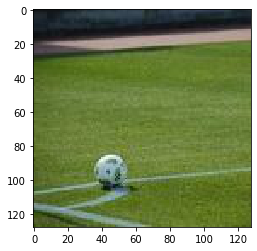

In [45]:
import PIL

input_shape = (128, 128, 3)

noise_image = np.random.random((1,) + input_shape)*2-1

path = "figure/test_img.jpg" #inpainting 

target_image, target_array=load_image(path, input_shape)

plt.imshow(target_array)

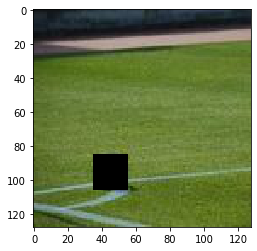

In [46]:
#For painting
mask, mask_array = make_mask(35, 55 ,85, 105, input_shape)

image_painted = painting(target_array, mask_array)

plt.imshow(image_painted)

In [49]:
#Start Inpainting
preprocess = lambda x : x / 127 -1

restore  = lambda x :((x + 1) * 127).astype(np.uint8)

target_img = preprocess(target_image)

model = DIP(input_shape)

inpainting_loss = lambda y_true, y_pred: loss_make(y_true, y_pred, mask) #for inpainging

trainer = Trainer(model, inpainting_loss, optimizer=Adam(1e-3))

trainer.train(noise_image, target_img, batch_size=1, epochs=400)


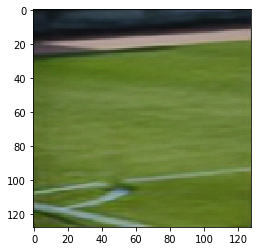

In [50]:
#inpainting
img_pred = model.predict(noise_image)
plt.imshow(np.reshape(restore(img_pred),(128,128,3)))